In [1]:
#this code introduces you to machine learning training and inference (predictions) in Python on AWS

#start a line with '!' to write to the command line instead. 
#This allows you to install packages to the EC2 instance from within jupyter
'''!pip install pandas
!pip install seaborn
!pip install sklearn
!pip install numpy'''

#import the packages that you installed
import pandas as pd
import seaborn.apionly as sns
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
import time
import matplotlib.pyplot as plt
%matplotlib inline

#load a default seaborn dataset, display simple stats about data size, and then print the data's head
df = pd.DataFrame(sns.load_dataset('iris'))
print 'shape of the data frame'+str(df.shape)
print df.groupby(['species']).size()
df.head(10)


shape of the data frame(150, 5)
species
setosa        50
versicolor    50
virginica     50
dtype: int64


/usr/local/lib/python2.7/dist-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
5,5.4,3.9,1.7,0.4,setosa
6,4.6,3.4,1.4,0.3,setosa
7,5.0,3.4,1.5,0.2,setosa
8,4.4,2.9,1.4,0.2,setosa
9,4.9,3.1,1.5,0.1,setosa


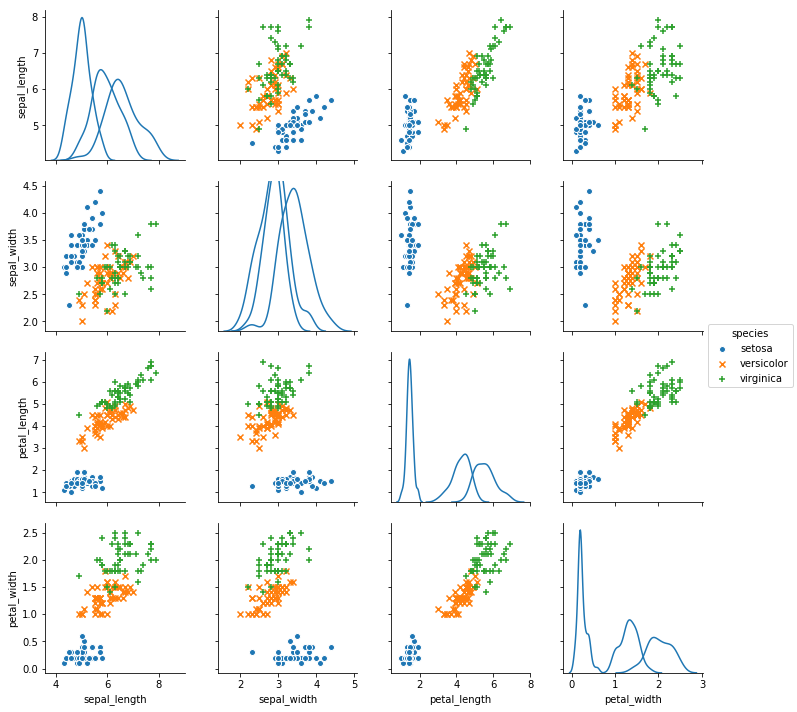

In [2]:
#showoff some of what seaborn can do
sns.pairplot(df, hue="species", diag_kind="kde",markers=['o','x','+'])

In [3]:
#let's group setosa and verginica together for the sake of this machine learning exercise
df['y']= np.where(df['species']=='versicolor', 1,0)
print df.groupby(['y']).size()

y
0    100
1     50
dtype: int64


In [4]:
#split into train and test
X=df.drop('species',1).drop('y',1)
y=df['y']
RANDOM_STATE=0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)
print ('the number in training set: '+str(len(X_train)))
print ('the number in test set: '+str(len(X_test)))

the number in training set: 112
the number in test set: 38


In [5]:
#Randomized search for model selection
clf = RandomForestClassifier(n_estimators=5)
# Utility function to report best scores
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean OOB score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 4),
              "min_samples_split": sp_randint(2, 5),
              "min_samples_leaf": sp_randint(1, 5),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 10
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

random_search.fit(X_train, y_train)
#this might take a minute to run
print("RandomizedSearchCV examined %d candidate parameter settings." % (n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV examined 10 candidate parameter settings.
Model with rank: 1
Mean OOB score: 0.964 (std: 0.025)
Parameters: {'bootstrap': True, 'min_samples_leaf': 3, 'min_samples_split': 4, 'criterion': 'gini', 'max_features': 2, 'max_depth': None}

Model with rank: 1
Mean OOB score: 0.964 (std: 0.012)
Parameters: {'bootstrap': True, 'min_samples_leaf': 2, 'min_samples_split': 4, 'criterion': 'gini', 'max_features': 1, 'max_depth': None}

Model with rank: 1
Mean OOB score: 0.964 (std: 0.025)
Parameters: {'bootstrap': False, 'min_samples_leaf': 1, 'min_samples_split': 2, 'criterion': 'gini', 'max_features': 3, 'max_depth': None}

Model with rank: 4
Mean OOB score: 0.955 (std: 0.033)
Parameters: {'bootstrap': True, 'min_samples_leaf': 2, 'min_samples_split': 3, 'criterion': 'entropy', 'max_features': 3, 'max_depth': None}

Model with rank: 4
Mean OOB score: 0.955 (std: 0.033)
Parameters: {'bootstrap': False, 'min_samples_leaf': 1, 'min_samples_split': 2, 'criterion': 'gini', 'max_fea

In [6]:
from sklearn.linear_model import LogisticRegression

In [7]:
# Code source: http://scikit-learn.org/stable/auto_examples/linear_model/
                #plot_logistic_multinomial.html#sphx-glr-auto-examples-linear-model-plot-logistic-multinomial-py

# Get training scores:

for multi_class in ('multinomial', 'ovr'):
    clf = LogisticRegression(solver='sag', max_iter=100, random_state=42,
                             multi_class=multi_class).fit(X, y)

    # print the training scores
    print("training score : %.3f (%s)" % (clf.score(X, y), multi_class))

training score : 0.720 (multinomial)
training score : 0.720 (ovr)


/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [8]:
# Apply last cell formula into confusion matrix
# Confusion matrix code from https://github.com/kljohnson721/ADS_Class/blob/master/intro_to_python_data_science_on_aws.ipynb
clf = LogisticRegression(solver='sag', max_iter=100, random_state=42,
                             multi_class='multinomial')

clf = clf.fit(X_train, y_train)
  
y_pred=clf.predict(X_test)
y_scores=clf.predict_proba(X_test)
print ('\nconfusion matrix')
print(pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_scores[:,1])
print('\nauc score '+str(auc(false_positive_rate, true_positive_rate)))

#show a tradeoff curve for precision vs recall


confusion matrix
Predicted   0  1  All
True                 
0          20  2   22
1          11  5   16
All        31  7   38

auc score 0.872159090909


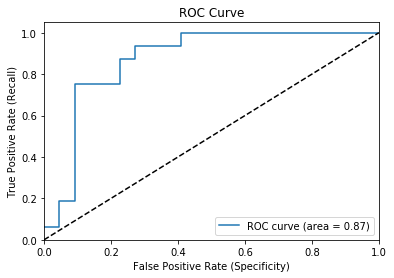

In [9]:
## ROC curve code from https://github.com/kljohnson721/ADS_Class/blob/master/intro_to_python_data_science_on_aws.ipynb
fpr, tpr , threshold = roc_curve(y_test,clf.predict_proba(X_test)[:,1])
roc_auc=auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
#Specificity: How many negatives were identified as negative.
plt.xlabel('False Positive Rate (Specificity)')
#Recall: How many positives were identified as positive.
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [10]:
import numpy as np
import matplotlib.pyplot as plt

training score : 0.960 (multinomial)
training score : 0.960 (ovr)


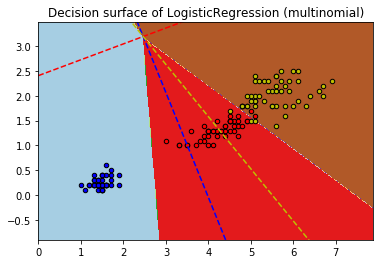

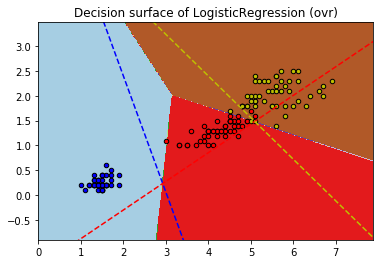

In [12]:
# Plot multinomial and One-vs-Rest Logistic Regression; code found from the following:

#http://scikit-learn.org/stable/auto_examples/linear_model/
  #plot_logistic_multinomial.html#sphx-glr-auto-examples-linear-model-plot-logistic-multinomial-py

# Reset the data first to make this code work

from sklearn import datasets
iris = datasets.load_iris()
X = iris.data[:, 2:4]  # Using the petal_length and petal_width features.
y = iris.target

for multi_class in ('multinomial', 'ovr'):
    clf = LogisticRegression(solver='sag', max_iter=100, random_state=42,
                             multi_class=multi_class).fit(X, y)

    # print the training scores
    print("training score : %.3f (%s)" % (clf.score(X, y), multi_class))

    # create a mesh to plot in
    h = .02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    plt.title("Decision surface of LogisticRegression (%s)" % multi_class)
    plt.axis('tight')
    
     # Plot also the training points
    colors = "bry"
    for i, color in zip(clf.classes_, colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired,
                    edgecolor='black', s=20)
        
    # Plot the three one-against-all classifiers
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    coef = clf.coef_
    intercept = clf.intercept_ 
    
    def plot_hyperplane(c, color):
        def line(x0):
            return (-(x0 * coef[c, 0]) - intercept[c]) / coef[c, 1]
        plt.plot([xmin, xmax], [line(xmin), line(xmax)],
                 ls="--", color=color)

    for i, color in zip(clf.classes_, colors):
        plot_hyperplane(i, color)
        
plt.show()


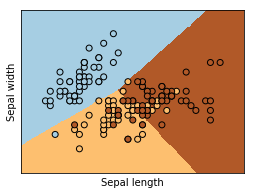

In [13]:
# Plot using Logistic Regression 3-class Classifier; code found from the following:

#http://scikit-learn.org/stable/auto_examples/linear_model/plot_iris_logistic.html
    #sphx-glr-auto-examples-linear-model-plot-iris-logistic-py

# Reset X
X = iris.data[:, :2]  # we only take two first two features.
Y = iris.target

clf = LogisticRegression(C=42)

# we create an instance of Neighbours Classifier and fit the data.
clf.fit(X, Y)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()


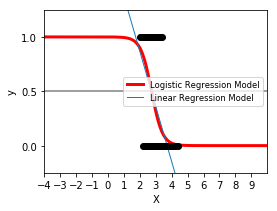

In [14]:
# Plot using a sigmoidal curve; code found from the following:

#http://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic.html

from sklearn import linear_model

clf = linear_model.LogisticRegression(C=42)

# Reset X and y
X=df.drop('species',1).drop('y',1)
df['y']= np.where(df['species']=='versicolor', 1,0)

X=df.iloc[:, 1:2].values
#X=df.drop('species',1).drop('y',1)
y=df['y']
#RANDOM_STATE=0
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)
clf.fit(X, y)

# and plot the result
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.scatter(X.ravel(), y, color='black', zorder=20)
X_test = np.linspace(-5, 10, 300)


def model(x):
    return 1 / (1 + np.exp(-x))
loss = model(X_test * clf.coef_ + clf.intercept_).ravel()
plt.plot(X_test, loss, color='red', linewidth=3)

ols = linear_model.LinearRegression()
ols.fit(X, y)
plt.plot(X_test, ols.coef_ * X_test + ols.intercept_, linewidth=1)
plt.axhline(.5, color='.5')

plt.ylabel('y')
plt.xlabel('X')
plt.xticks(range(-5, 10))
plt.yticks([0, 0.5, 1])
plt.ylim(-.25, 1.25)
plt.xlim(-4, 10)
plt.legend(('Logistic Regression Model', 'Linear Regression Model'),
           loc="center right", fontsize='small')
plt.show()







In [15]:
import pickle
local_path = "/home/ubuntu" # temp path to export your model
bucket_name = "jpopbucket" # s3 key to save your network to


# save the model to disk
filename = 'HW2.ipynb'
pickle.dump(clf, open(filename, 'wb'))
#you should now see your finalized_model.sav in the file path
#the ls command prints the contents of this notebook's root folder
!ls
 
# Upload to S3
#TO GET THIS WORKING, YOU MUST ASSIGN AN ADMIN ROLE TO YOUR EC2 INSTANCE
import boto3
s3 = boto3.resource('s3')
s3.Bucket(bucket_name).put_object(Key='HW2.ipynb', Body=open('HW2.ipynb'))

finalized_model.sav  HW2.ipynb	seaborn-data  src  Test.ipynb


s3.Object(bucket_name='jpopbucket', key='HW2.ipynb')